In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import skill_metrics as sm

# 平均态统计关系，泰勒图
2021.12.22

计算泰勒图诸要素，进行绘制，降水和气温分开在两个脚本中

## 数据读入

目标处理：1991-2015年数据

In [2]:
path_in = "/raid61/LS4P-TPEMIP/TEMP_DATA/precip_mask/"
ds_in = {}
dir_obs_in ="/raid61/LS4P-TPEMIP/REFERENCE/CN05.1/"
ds_in['obs'] = xr.open_dataset(dir_obs_in + "sel_CN05.1_Pre_1961_2018_daily_025x025.nc").rename({"pre":"pr"})
# ds_in[''] = xr.open_dataset(path_in + "")
ds_in['CWRF'] = xr.open_dataset(path_in + "CWRF_pre.nc") # 缺少逐日数据，只有多种尺度的平均态数据
ds_in['JAMSTECWRF'] = xr.open_dataset(path_in + "JAMSTECWRF_pre.nc") # 缺少4月
ds_in['NJU_LS4P_B'] = xr.open_dataset(path_in + "NJU_LS4P_B_pre.nc")
ds_in['NJU_LS4P_C'] = xr.open_dataset(path_in + "NJU_LS4P_C_pre.nc")
ds_in['NJU_Output-E'] = xr.open_dataset(path_in + "NJU_Output-E_pre.nc") # 缺少2015年
ds_in['SYS'] = xr.open_dataset(path_in + "SYS_pre.nc")
ds_in['Yang-ZhouX'] = xr.open_dataset(path_in + "Yang-ZhouX_pre.nc")
ds_in['YSU'] = xr.open_dataset(path_in + "YSU_pre.nc")

In [3]:
# 稍微处理一下变量名，用于后续的处理
for single_mod in ds_in:
    print(single_mod)
    list_vars = list(ds_in[single_mod].variables)
    print(list_vars)
#     print(ds_in[single_mod].coords)
    if ('Time' in list_vars):
        print('----- rename Time>>>time')
        ds_in[single_mod] = ds_in[single_mod].rename({"Time":"time"})
    if ('pr' not in list_vars):
        print('------ rename ???pre???>>>pr')
        ds_in[single_mod] = ds_in[single_mod].rename({"dailypre":"pr"})
    if (ds_in[single_mod].time.shape[0] !=3825):
        print("**********time error in " + single_mod + " !" + " time length:" + str(ds_in[single_mod].time.shape[0]) )

obs
['time', 'lon', 'lat', 'pr']
CWRF
['pr', 'lon', 'lat', 'time']
**********time error in CWRF ! time length:12
JAMSTECWRF
['pr', 'lon', 'lat', 'time']
**********time error in JAMSTECWRF ! time length:3075
NJU_LS4P_B
['pr', 'lon', 'lat', 'time']
NJU_LS4P_C
['pr', 'lon', 'lat', 'time']
NJU_Output-E
['pr', 'lon', 'lat', 'time']
SYS
['pr', 'lon', 'lat', 'time']
Yang-ZhouX
['pr', 'lon', 'lat', 'time']
YSU
['pr', 'lon', 'lat', 'time']


## 逐月平均态计算

In [4]:
var_am = {}
var_jja= {}
var_everymonth = {}
for single_mod in ds_in:
    temp_time = ds_in[single_mod].time
    var_everymonth[single_mod] = ds_in[single_mod]['pr'].groupby(temp_time.dt.month).mean(dim = 'time')

### 逐月泰勒图诸要素计算

In [5]:
taylor_space = {}
models_list =  ['CWRF','JAMSTECWRF', 'NJU_LS4P_B', 'NJU_LS4P_C', 'NJU_Output-E', 'SYS', 'Yang-ZhouX', 'YSU']
for mod_name in models_list:
#     print(mod_name)
    taylor_space[mod_name] = {}
    for single_month in range(4,9,1):
#         print(single_month)
        if ( (single_month == 4) & (mod_name == 'JAMSTECWRF')):
            continue
        # 逐月的空间平均整理出1D序列
        obs_1d = var_everymonth['obs'].sel(month = single_month).values.ravel()
        mod_1d = var_everymonth[mod_name].sel(month = single_month).values.ravel()
        mod_nan_ind = np.isnan(mod_1d)
        # taylor count
        taylor_space[mod_name][single_month] = sm.taylor_statistics(mod_1d[~mod_nan_ind], obs_1d[~mod_nan_ind])
        # normalized 注意先后顺序，先归一化CRMSD，再SDEV，否则用归一化后的SDEV计算RMSD会出现问题
        taylor_space[mod_name][single_month]['crmsd'] = taylor_space[mod_name][single_month]['crmsd'] / taylor_space[mod_name][single_month]['sdev'][0]
        taylor_space[mod_name][single_month]['sdev'] = taylor_space[mod_name][single_month]['sdev'] / taylor_space[mod_name][single_month]['sdev'][0]

### 制表部分

In [6]:
table_taylor_metrics = []
models_list =  ['CWRF','JAMSTECWRF', 'NJU_LS4P_B', 'NJU_LS4P_C', 'NJU_Output-E', 'SYS', 'Yang-ZhouX', 'YSU']
for model in models_list:    
    for season in range(4,9,1):
        if ( (season == 4) & (model == 'JAMSTECWRF')):
            continue
        dict_temp = {ikeys : taylor_space[model][season][ikeys][1] for ikeys in taylor_space[model][season]}
#         table_temp = pd.DataFrame.from_dict( taylor_space[model][season] ) 
        table_temp = pd.DataFrame( dict_temp, index = [model   +" in "+ str(season)]) 
        table_temp['model']  = model
        table_temp['season'] = season
        table_taylor_metrics.append(table_temp)

table_taylor_metrics = pd.concat(table_taylor_metrics)
# table_taylor_metrics
# table_taylor_metrics.loc['crmsd']
# table_taylor_metrics.loc['sdev']

In [7]:
table_taylor_metrics.to_csv("./output_table/pre_taylor_spatialall.csv")

## 绘图部分

skip!


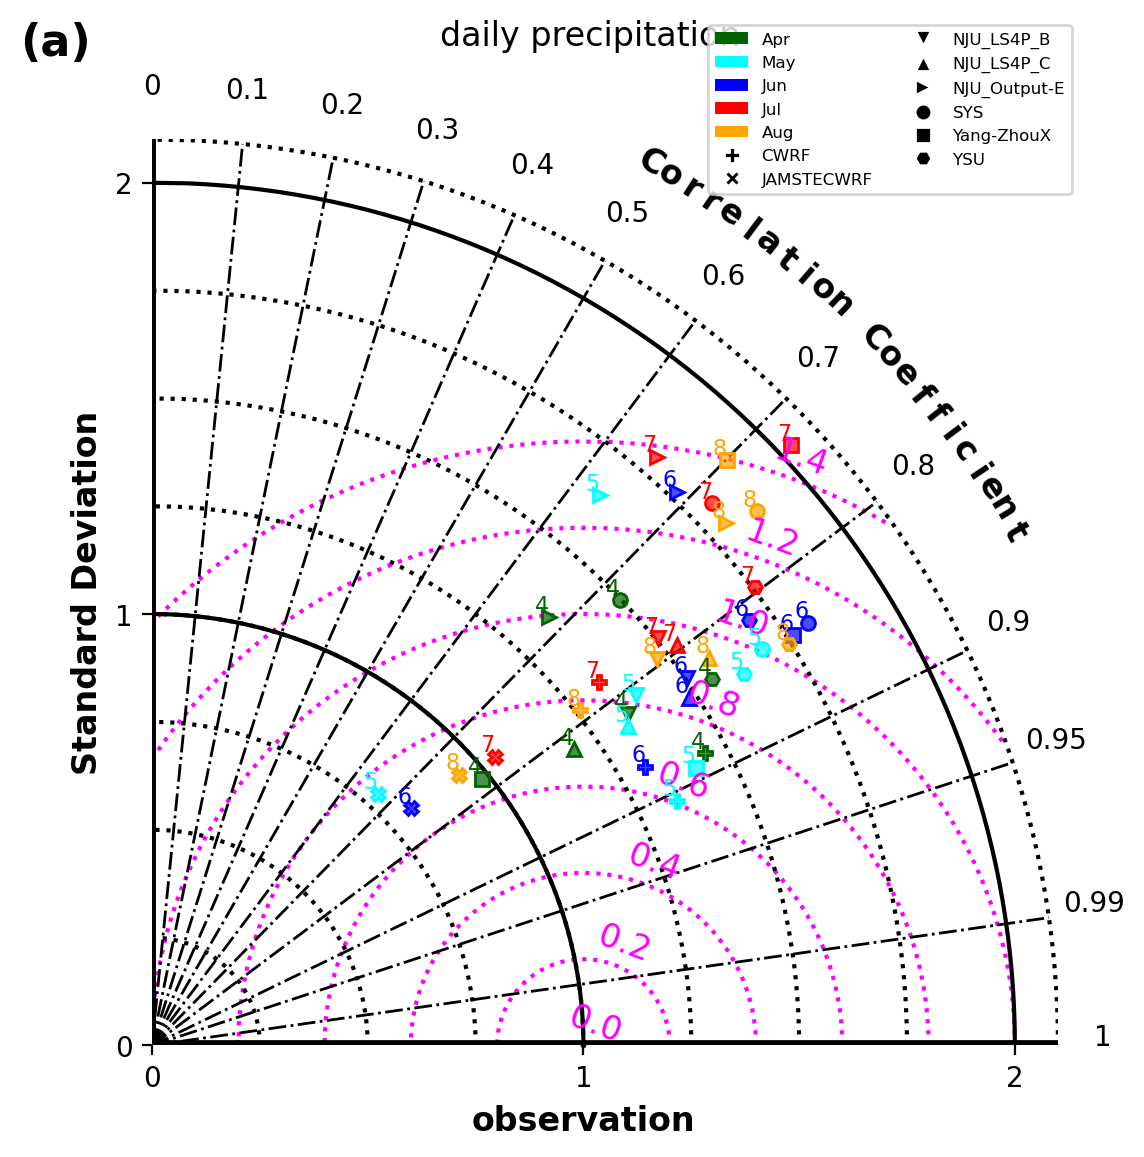

In [8]:
fig = plt.figure(figsize=(6, 6), dpi=200)

first_plot = True # 开关，用于是否进行点的叠加
models_list =  ['CWRF','JAMSTECWRF', 'NJU_LS4P_B', 'NJU_LS4P_C', 'NJU_Output-E', 'SYS', 'Yang-ZhouX', 'YSU']

for single_month in range(4,9,1):
    for mod_name in models_list:    
        if ( (single_month == 4) & (mod_name == 'JAMSTECWRF')):
            print("skip!")
            continue
        # 获取每个点的泰勒图诸要素
        sdev_plot = taylor_space[mod_name][single_month]['sdev']
        crmsd_plot = taylor_space[mod_name][single_month]['crmsd']
        ccoef_plot = taylor_space[mod_name][single_month]['ccoef']
        
        # 使用字典指定各个点的颜色、形状等特征
        color_loops = ['green','lawngreen','aqua','cadetblue','blue','red','orange','y'] # 不同模式用颜色区分
        color_for_everymodels =dict(zip(models_list, color_loops))
        shape_loops_models = ['P', 'X', 'v',"^",'>','o','s','H']
        shape_for_everymodels = dict(zip(models_list, shape_loops_models))
        color_loops = ['darkgreen','aqua','blue','red','orange'] # 不同模式用颜色区分
        color_for_everymonth = dict(zip([4,5,6,7,8], color_loops))
        
        # taylor diagram
        sm.taylor_diagram(sdev_plot,crmsd_plot,ccoef_plot, 
        #----- mark setting -----
        MarkerDisplayed = 'marker',
        # numberPanels = 1,
        markerLabel = ['obs', str(single_month)],
        markerlegend = "off",
        markerLabelColor = color_for_everymonth[single_month],
        markerColor = color_for_everymonth[single_month],
        markersymbol = shape_for_everymodels[mod_name],
        markerSize = 5,
        alpha = .7, 
        # -----RNSD-----
        # tickRMS = np.arange(0,1.8,0.2),
        tickRMS = np.arange(0,1.6,0.2),
        tickRMSangle = 70, 
        colRMS = 'fuchsia', styleRMS = ':', widthRMS = 1.5,
        # tickCOR = lsCOR,
        showlabelsRMS = "on",
        titleRMS = "off",
        rmslabelformat = ':.1f',
        # -----COR-----
        colCOR = "k", 
        widthCOR = 1.0,
        # -----STD------
        tickSTD = np.arange(0,2.1,0.25), axismax = 2.1, 
        showlabelsSTD = 'on',
        # -----marker reference-----
        styleOBS = '-', 
        colOBS = 'k',
        markerobs = 'o', 
        overlay = not first_plot,
        titleOBS = 'observation',
        # ------ check -----
        checkStats = True,
        )
        # break
        first_plot = False
        
#  legend设置，颜色以及型号
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
legend_elements = []
month_name = {4:'Apr',5:"May",6:"Jun",7:"Jul",8:"Aug"}
for i in color_for_everymonth.items():
    legend_elements.append( Patch(facecolor=i[1],label=month_name[i[0]] ))

for i in  shape_for_everymodels.items():
    legend_elements.append( Line2D([0], [0], marker=i[1], color='w', label=i[0], linestyle=None,
                          markerfacecolor='k', markersize=6)) 

fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(.9,0.95),prop={'size': 6}, ncol=2)
fig.suptitle("daily precipitation")
fig.text(0.025,.95,"(a)", fontsize = 16, fontweight = "bold", color = 'k')

#saving pics
plt.savefig("./output_pic/pre_taylor_spatialall.png",dpi=600, facecolor = 'white')